In [2]:
import numpy as np
import camb
import matplotlib.pyplot as plt
import time

# Q1) 

chisq is  3272.2033778089576  for  2501  degrees of freedom.


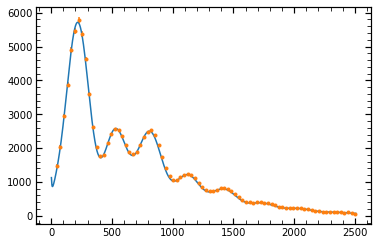

In [3]:
# Copied code from planck_likelihood

def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    
    return tt[2:]


plt.ion()

pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95]) #np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
#print('The number of data point', len(spec))
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum((resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

The $\chi^2$ value from the test-script parameters is quite large (15267.937968222595) and therefore, the parameters are not an acceptable fit. For parameters equal to [69,0.022,0.12,0.06,2.1e-9,0.95], $\chi^2$ is 3272.2033778089576.

# Q2) Use Newton's method or LM to find the best-fit parameters, using numerical derivatives. Your code should report your best-fit parameters and their errors in planck_fit_params.txt. Please write your own fitter/numerical-derivative-taker rather than stealing one. Keep track of curvature matrix at the best-fit values for the next problem. What are best-fit parameters with the DM density set to zero - how does this $\chi^2$ compare to the standard value? If you get this to work, print the parameters/errors  in planck_fit_params_nodm.txt.

We will write a LM non-linear least squares method using the double-sided derivative approximation to compute the numerical derivatives w.r.t. each of the model parameters. These derivatives will take the form, 

\begin{equation}
\frac{df}{dx_i} = \frac{f(x_i+\delta) - f(x_i-\delta)}{2\delta}
\end{equation}

for $x_i$ the parameter the derivative is taken with respect to. We will take the $\delta$ values to approximately one hundredth of the parameter value to ensure our step sizes are neither too large nor too small.

In [4]:
# LM functions

def get_model_derivs(params, deltas, lmax=3000):
    # 6 model parameters
    H0, omegabh2, omegaCh2, tau, A, ns = params
    
    # deltas for derivative
    delta0, delta1, delta2, delta3, delta4, delta5 = deltas
    
    # Model corresponding to params given
    mod = get_spectrum(params)
    
    # Use double sided derivative approximation to compute numerical derivatives given delta
    dH0 = (get_spectrum([H0+delta0, omegabh2, omegaCh2, tau, A, ns])-get_spectrum([H0-delta0, omegabh2, omegaCh2, tau, A, ns]))/(2*delta0)
    domegabh2 = (get_spectrum([H0, omegabh2+delta1, omegaCh2, tau, A, ns])-get_spectrum([H0, omegabh2-delta1, omegaCh2, tau, A, ns]))/(2*delta1)
    domegaCh2 = (get_spectrum([H0, omegabh2, omegaCh2+delta2, tau, A, ns])-get_spectrum([H0, omegabh2, omegaCh2-delta2, tau, A, ns]))/(2*delta2)
    dtau = (get_spectrum([H0, omegabh2, omegaCh2, tau+delta3, A, ns])-get_spectrum([H0, omegabh2, omegaCh2, tau-delta3, A, ns]))/(2*delta3)
    dA = (get_spectrum([H0, omegabh2, omegaCh2, tau, A+delta4, ns])-get_spectrum([H0, omegabh2, omegaCh2, tau, A-delta4, ns]))/(2*delta4)
    dns = (get_spectrum([H0, omegabh2, omegaCh2, tau, A, ns+delta5])-get_spectrum([H0, omegabh2, omegaCh2, tau, A, ns-delta5]))/(2*delta5)    
    
    # Put derivatives into an array to use in LM method
    derivs = np.zeros([len(dH0), len(params)]) # lmax is number of moments
    derivs[:,0] = dH0
    derivs[:,1] = domegabh2
    derivs[:,2] = domegaCh2
    derivs[:,3] = dtau
    derivs[:,4] = dA
    derivs[:,5] = dns
    
    return mod, derivs

def update_lmbda(lmbda, success):
    """
    Update lambda value for the Levenberg-Marquandt based on the success of the previous step. 
    Outline taken from class code.
    """
    if success == False:
        if lmbda == 0:
            lmbda = 1
        else:
            lmbda = 2*lmbda
    else:
        if lmbda < 0.2:
            lmbda = 0
        else:
            lmbda = lmbda/np.sqrt(2)
    return lmbda

In [28]:
# Define data
params = np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95]) # initial guess params from script
deltas = [0.1,1e-4,1e-3,1e-4,1e-11,1e-3]
model, derivs = get_model_derivs(params, deltas) 

# chi-square for Gaussian, uncorrelated errors
model, derivs = model[:len(spec)], derivs[:len(spec)]
res = spec-model
chisq = np.sum((res/errs)**2)
Ninv = np.diag(1/errs**2) # put errors into matrix form for matrix multiplication
chisq_accept = [float(chisq)] # all accepted chi-square values
lmbda = 0 # initalize lambda = 0 
chisq_threshold = 0.01
num_iter = 50

for i in range(num_iter):
    '''
    Equation to solve: (J^T @ N^{-1} @ J + lambda*diag(J^T @ N^{-1} @ J))*dp =  J^T @ N^{-1} @ (y-y(p)) for
    J = Jacobian, N = 1/errors
    '''
    rhs = derivs.T@Ninv@res #(derivs.T/errs)@ res
    lhs = derivs.T@Ninv@derivs + lmbda*np.diag(np.diag(derivs.T@Ninv@derivs))
    lhs_inv = np.linalg.inv(lhs)
    new_cov = lhs_inv
    new_params = params + lhs_inv@rhs # old params + param_update
    new_model, new_derivs = get_model_derivs(new_params, deltas)
    new_model, new_derivs = new_model[:len(spec)], new_derivs[:len(spec)]
    new_res =  spec - new_model
    new_chisq = np.sum((new_res/errs)**2)
    delta_chisq = new_chisq - chisq
    print('Step '+repr(i+1)+': chi-squared change = '+repr(delta_chisq))
    if new_chisq <= chisq: # update all variables given successful step
        res = new_res
        chisq = new_chisq
        derivs = new_derivs
        params = new_params
        cov = new_cov
        lmbda = update_lmbda(lmbda, success=True)
        print('Successful step, updating lambda to '+repr(lmbda)+'.')
        chisq_accept.append(float(chisq)) # keep list of accepted chi-square values

        # Stop once the delta_chisq < chisq_threshold and lmbda = 0 (and not the first step)
        if  (i > 0) and (lmbda == 0) and (np.abs(delta_chisq) < chisq_threshold):
            print('Solution coverged after '+repr(i+1)+' iterations.')
            break
    else:
        lmbda = update_lmbda(lmbda, success=False) # update lmbda given unsuccessful steps
        print('Unsuccessful step, updating lambda to '+repr(lmbda)+'.')

# Now write the best fit params and their errors to a txt file

fobj = open(r"planck_fit_params.txt","w")
string = ''
params_name = ['H0: ', 'Omegabh2: ', 'OmegaCh2: ', 'tau: ', 'Amp: ', 'ns: ']
for i in range(len(params)):
    string += params_name[i] + str(params[i])+' +/- ' + str(np.sqrt(np.abs(np.diag(cov)))[i]) + '\n'
fobj.write(string)
fobj.close()

Step 1: chi-squared change = -683.2500706686956
Successful step, updating lambda to 0.
Step 2: chi-squared change = -11.21583185912641
Successful step, updating lambda to 0.
Step 3: chi-squared change = -1.566520567547741
Successful step, updating lambda to 0.
Step 4: chi-squared change = -0.0179969052933302
Successful step, updating lambda to 0.
Step 5: chi-squared change = -0.000659116974020435
Successful step, updating lambda to 0.
Solution coverged after 5 iterations.


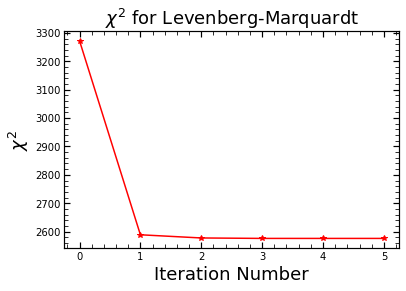

In [34]:
# Now plot Chi-square evolution to verify it has converged or is at least decreasing with st

plt.plot(chisq_accept, 'r*-')
plt.xlabel('Iteration Number', fontsize=18)
plt.ylabel('$\chi^2$', fontsize=18)
plt.title('$\chi^2$ for Levenberg-Marquardt', fontsize=18);

# Q3) Write an MCMC sampler. Draw trial steps from curvature matrix from Q2. Save your chain, including the corresponding $\chi^2$ values in planck_chain.txt. Explain why you think your chains have converged. What is your estimate on the mean value of dark energy $\Omega_{\Lambda}$ and its uncertainty (given $\Omega_{b}$+$\Omega_{C}$+$\Omega_{\Lambda}$=1).

To verify chain the has converged, look at the $\chi^2$ evolution with time (steps). If $\chi^2$ has stabilized by the end of the chain, remaining relatively constant over a significant number of steps, we can say with decent confidence that the chain has converged. Therefore, plotting $\chi^2$ vs step number, we see the following.

To estimate the mean value of the dark energy, we can consider the formula, 

\begin{equation}
\Omega_{b}+\Omega_{C}+\Omega_{\Lambda}=1 \implies \Omega_{\Lambda}=1 - \Omega_{b} - \Omega_{C}
\end{equation}

where we have solved for $\Omega_{b}h^2$ and $\Omega_{C}h^2$, for $h=H_0/100$, where we have also estimate $H_0$. Therefore, we can estimate $\Omega_{\Lambda}$ as, 


\begin{equation}
\Omega_{\Lambda}= 1 - \frac{100^2 \Omega_{b} h^2}{H_0^2} - \frac{100^2 \Omega_{C} h^2}{H_0^2} 
\end{equation}

and its uncertainty as,

\begin{equation}
\delta \Omega_{\Lambda} = \sqrt{\left(\frac{d\Omega_{\Lambda}}{d\Omega_{b}h^2} \delta \Omega_{b}h^2\right)^2 + \left(\frac{d\Omega_{\Lambda}}{d\Omega_{C}h^2} \delta \Omega_{C}h^2\right)^2 + \left(\frac{d\Omega_{\Lambda}}{dH_0}\delta H_0\right)^2}.
\end{equation}

[-9.36030469e+03  8.79400040e+06 -4.71920490e+06 -1.68257215e+06
  3.97217431e+14  4.95751450e+05] 
 [-9.36030469e+03  8.79400040e+06 -4.71920490e+06 -1.68257215e+06
  3.97217431e+14  4.95751450e+05]
NOOO
NOOO
NOOO
NOOO
NOOO
NOOO


In [91]:
Ninv = np.linalg.inv(np.diag(errs))
print(derivs.T@Ninv@res)
print((derivs.T/errs @ res))

[ 1.48410157e+01  1.34181249e+04 -3.60436700e+03 -6.86229266e+02
 -2.45415362e+11  5.85416405e+02]
[ 1.48410157e+01  1.34181249e+04 -3.60436700e+03 -6.86229266e+02
 -2.45415362e+11  5.85416405e+02]


In [95]:
fobj = open(r"planck_fit_params.txt","w")
string = ''
params_name = ['H0: ', 'Omegabh2: ', 'OmegaCh2: ', 'tau: ', 'Amp: ', 'ns: ']
for i in range(len(params)):
    string += params_name[i] + str(params[i])+' +/- ' + str(np.sqrt(np.abs(np.diag(cov)))[i]) + '\n'
fobj.write(string)
fobj.close()

In [7]:
Ninv = np.diag(1/errs**2)
Ninv2 = np.linalg.inv(np.diag(errs**2))

In [8]:
print(Ninv, Ninv2)

[[9.03345599e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.44674147e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.33503802e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.10013313e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.05408124e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 8.01246166e-05]] [[9.03345599e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.44674147e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.33503802e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.10013313e-05
  0.00000000e+00 0.00000000e+00]